In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.image import pad_to_bounding_box, resize, random_crop, random_flip_left_right
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D, concatenate, BatchNormalization, Activation
from keras.applications import MobileNetV3Large
from keras.applications.mobilenet_v3 import preprocess_input
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy, Recall, Accuracy, Precision

In [ ]:
%cd /content/drive/MyDrive/sj/dacon/cancer_transfer_prediction

/content/drive/MyDrive/sj/dacon/cancer_transfer_prediction


In [ ]:
config = {
    'IMG_SIZE': 224,
    'EPOCHS':10,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':32,
    'SEED':41
}

In [ ]:
df = pd.read_csv("train.csv")
df.head()

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,BC_01_0001,./train_imgs/BC_01_0001.png,-,63,2015-10-23,1,2,1,19.0,2.0,...,8.0,1.0,6.0,12.0,0.0,1.0,NaN,NaN,NaN,0
1,BC_01_0002,./train_imgs/BC_01_0002.png,-,51,2015-10-28,1,1,1,22.0,3.0,...,NaN,0.0,NaN,70.0,0.0,0.0,NaN,NaN,NaN,1
2,BC_01_0003,./train_imgs/BC_01_0003.png,-,37,2015-10-29,1,2,1,NaN,2.0,...,7.0,1.0,4.0,7.0,0.0,1.0,NaN,NaN,0.0,0
3,BC_01_0004,./train_imgs/BC_01_0004.png,-,54,2016-03-08,1,2,1,0.0,3.0,...,NaN,0.0,NaN,1.0,1.0,3.0,NaN,NaN,NaN,0
4,BC_01_0005,./train_imgs/BC_01_0005.png,-,57,2015-10-30,1,2,1,8.0,2.0,...,8.0,0.0,NaN,8.0,1.0,2.0,1.0,5.44,NaN,0


In [ ]:
df['암의 장경'] = round(df['암의 장경'].fillna(df['암의 장경'].mean()), 1)
df = df.fillna(0)
df.head()

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,BC_01_0001,./train_imgs/BC_01_0001.png,-,63,2015-10-23,1,2,1,19.0,2.0,...,8.0,1.0,6.0,12.0,0.0,1.0,0.0,0.00,0.0,0
1,BC_01_0002,./train_imgs/BC_01_0002.png,-,51,2015-10-28,1,1,1,22.0,3.0,...,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.00,0.0,1
2,BC_01_0003,./train_imgs/BC_01_0003.png,-,37,2015-10-29,1,2,1,18.4,2.0,...,7.0,1.0,4.0,7.0,0.0,1.0,0.0,0.00,0.0,0
3,BC_01_0004,./train_imgs/BC_01_0004.png,-,54,2016-03-08,1,2,1,0.0,3.0,...,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.00,0.0,0
4,BC_01_0005,./train_imgs/BC_01_0005.png,-,57,2015-10-30,1,2,1,8.0,2.0,...,8.0,0.0,0.0,8.0,1.0,2.0,1.0,5.44,0.0,0


In [ ]:
df = df.drop(["ID", "mask_path", "수술연월일"], axis=1)
df.head()

,img_path,나이,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,HG_score_2,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,./train_imgs/BC_01_0001.png,63,1,2,1,19.0,2.0,1.0,2.0,2.0,...,8.0,1.0,6.0,12.0,0.0,1.0,0.0,0.00,0.0,0
1,./train_imgs/BC_01_0002.png,51,1,1,1,22.0,3.0,3.0,3.0,3.0,...,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.00,0.0,1
2,./train_imgs/BC_01_0003.png,37,1,2,1,18.4,2.0,0.0,0.0,0.0,...,7.0,1.0,4.0,7.0,0.0,1.0,0.0,0.00,0.0,0
3,./train_imgs/BC_01_0004.png,54,1,2,1,0.0,3.0,3.0,3.0,3.0,...,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.00,0.0,0
4,./train_imgs/BC_01_0005.png,57,1,2,1,8.0,2.0,2.0,3.0,2.0,...,8.0,0.0,0.0,8.0,1.0,2.0,1.0,5.44,0.0,0


In [ ]:
numeric_cols = ['나이', '암의 장경', 'ER_Allred_score', 'PR_Allred_score', 'KI-67_LI_percent', 'HER2_SISH_ratio']
ignore_cols = ["img_path", "N_category"]
for col in df.columns:
    if col in ignore_cols:
        continue
    if col in numeric_cols:
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

df.head()

,img_path,나이,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,HG_score_2,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,./train_imgs/BC_01_1056.png,0.455882,1,2,1,0.245455,3.0,3.0,3.0,3.0,...,0.000,0.0,0.000000,0.000000,0.0,2.0,0.0,0.012128,0.0,1
1,./train_imgs/BC_01_2388.png,0.279412,1,2,1,0.300000,2.0,2.0,3.0,2.0,...,0.000,0.0,0.000000,0.206186,1.0,3.0,0.0,0.000000,0.0,1
2,./train_imgs/BC_01_2959.png,0.397059,1,1,1,0.172727,0.0,1.0,3.0,2.0,...,0.000,1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0
3,./train_imgs/BC_01_2243.png,0.220588,4,2,1,0.045455,1.0,1.0,1.0,1.0,...,1.000,1.0,0.111111,0.020619,0.0,2.0,0.0,0.000000,0.0,0
4,./train_imgs/BC_01_2736.png,0.470588,1,1,1,0.072727,2.0,1.0,2.0,2.0,...,0.875,0.0,0.000000,0.103093,1.0,2.0,0.0,0.000000,0.0,0


In [ ]:
df.shape

(1000, 25)

In [ ]:
df = df.sample(frac=1, random_state=config['SEED']).reset_index(drop=True)
df_train, df_valid = df.iloc[:int(len(df) * 0.8)], df.iloc[int(len(df) * 0.8):]
df_train.shape, df_valid.shape

((800, 25), (200, 25))

In [ ]:
df_train["N_category"].value_counts().sort_index()

0    397
1    403
Name: N_category, dtype: int64

In [ ]:
# generate image, tabluar, label
def generator_train():
    for item in df_train.values:
        yield (item[0], item[1:-1], item[-1])

def generator_valid():
    for item in df_valid.values:
        yield (item[0], item[1:-1], item[-1])
    
dataset_train = tf.data.Dataset.from_generator(
    generator_train,
    (tf.string, tf.float32, tf.int32),
    ((), (23,), ())
    )

dataset_valid = tf.data.Dataset.from_generator(
    generator_valid,
    (tf.string, tf.float32, tf.int32),
    ((), (23,), ())
    )

def augmentation(image):
    # add padding
    h, w = image.shape[0], image.shape[1]
    size = h if h >= w else w
    dst = pad_to_bounding_box(image, int((size-h)/2), int((size-w)/2), size, size)
    dst = resize(dst, size=(config['IMG_SIZE'], config['IMG_SIZE']))

    # image augmentation
    # dst = random_crop(dst, size=(int(config['IMG_SIZE'] * 0.9), int(config['IMG_SIZE'] * 0.9), 3))
    # dst = resize(dst, size=(config['IMG_SIZE'], config['IMG_SIZE']))
    dst = random_flip_left_right(dst)
    dst = tf.cast(dst, tf.float32)
    dst /= 255
    
    return dst

def preprocessing(path, category, label):
    bin = tf.io.read_file(path)
    image = tf.io.decode_png(bin, channels=3)
    image= tf.py_function(augmentation, [image], [tf.float32])
    image = tf.squeeze(image)
    return (image, category), label

dt = dataset_train.map(preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dt = dt.batch(config['BATCH_SIZE']).prefetch(3)
dv = dataset_valid.map(preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dv = dv.batch(config['BATCH_SIZE']).prefetch(3)

(224, 224, 3)
tf.Tensor(
[ 0.20624748  1.          2.          1.          0.7424444   3.
  3.          3.          3.          3.          2.          0.
  2.          0.         -1.47517     0.         -0.9119931  -0.75937045
  0.          2.          0.          0.21987177  0.        ], shape=(23,), dtype=float32)
tf.Tensor([1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1], shape=(32,), dtype=int32)


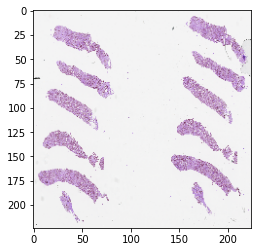

In [ ]:
for (image, clinical), label in dt.take(1):
    print(image[0].shape)
    print(clinical[0])
    print(label)
    plt.imshow(image[0])
    plt.show()

In [ ]:
mobilenet = MobileNetV3Large(include_top=False, input_shape=[config['IMG_SIZE'], config['IMG_SIZE'], 3], weights='imagenet')

input1 = Input(shape=(config['IMG_SIZE'], config['IMG_SIZE'], 3), dtype=tf.float32)

x = preprocess_input(input1)
x = tf.squeeze(x)
x = mobilenet(x)

x = GlobalAveragePooling2D()(x)

input2 = Input(shape=(23,), dtype=tf.float32)
x = concatenate([x, input2])

x = Dense(256)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(64)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(16)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(1, activation='sigmoid')(x)

#model
model = tf.keras.models.Model(inputs=[input1, input2], outputs=[output])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.compat.v1.squeeze_1 (TFOpLa  None                0           ['input_5[0][0]']                
 mbda)                                                                                            
                                                                                                  
 MobilenetV3large (Functional)  (None, 7, 7, 960)    2996352     ['tf.compat.v1.squeeze_1[0][0]'] 
                                                                                            

In [ ]:
# Accuracy vs BinaryAccuracy

y_true = [[1], [1], [0], [0]]
y_pred = [[0.51], [1], [0.49], [0]]

print(tf.keras.metrics.Accuracy()(y_true, y_pred))  # 0.5
print(tf.keras.metrics.BinaryAccuracy()(y_true, y_pred)) # 1.0

tf.Tensor(0.5, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


In [ ]:
mc = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/sj/dacon/cancer_transfer_prediction/model_best.h5", 
                                        monitor='val_loss', mode='min', verbose=1, save_best_only=True)

mobilenet.trainable = True
model.compile(optimizer=Adam(learning_rate=config['LEARNING_RATE']), 
              loss=BinaryCrossentropy(from_logits=False), 
              metrics=[Accuracy(), Recall()])
model.fit((dt), epochs=10, validation_data=(dv), callbacks=[mc])

Epoch 1/10
     25/Unknown - 98s 4s/step - loss: 1.1102 - accuracy: 0.0000e+00 - recall_1: 0.5112
Epoch 1: val_loss improved from inf to 0.69849, saving model to /content/drive/MyDrive/sj/dacon/cancer_transfer_prediction/model_best.h5
25/25 [==============================] - 127s 5s/step - loss: 1.1102 - accuracy: 0.0000e+00 - recall_1: 0.5112 - val_loss: 0.6985 - val_accuracy: 0.0000e+00 - val_recall_1: 0.5946
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 1.0077 - accuracy: 0.0000e+00 - recall_1: 0.5112
Epoch 2: val_loss did not improve from 0.69849
25/25 [==============================] - 72s 3s/step - loss: 1.0077 - accuracy: 0.0000e+00 - recall_1: 0.5112 - val_loss: 0.7162 - val_accuracy: 0.0000e+00 - val_recall_1: 0.0991
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 1.0310 - accuracy: 0.0000e+00 - recall_1: 0.4938
Epoch 3: val_loss did not improve from 0.69849
25/25 [==============================] - 73s 3s/step - loss: 1.0310 - accuracy

KeyboardInterrupt: ignored